A function for plotting

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import matplotlib.mlab as mlab
import time
%matplotlib inline


def plot_it(x_min=-2,
            x_max=2, 
            y_min=-2, 
            y_max=2, 
            npts=8000, 
            dataset=[], 
            nn_callback=None):
    xi = np.linspace(x_min, x_max, 100)
    yi = np.linspace(y_min, y_max, 100)


    x = np.random.uniform(x_min, x_max, npts)
    y = np.random.uniform(y_min, y_max, npts)
    if nn_callback is not None:
        z=[]
        for i in range(npts):
            #forward_pass(nn, [x[i], y[i]])[0]
            z.append(nn_callback(nn, [x[i], y[i]])[0] )
        zi = mlab.griddata(x, y, z, xi, yi, interp='linear')
        plt.contour(xi, yi, zi, 0, linewidths=0.5, colors='k')
        plt.contourf(xi, yi, zi, 15,
                     norm=plt.Normalize(vmax=abs(zi).max(), 
                                        vmin=-abs(zi).max()))
        plt.colorbar()  # draw colorbar
    
        

    tr_points_x = [a[0] for a, b in dataset if b == [1,0]]
    tr_points_y = [a[1] for a, b in dataset  if b == [1,0]]
    plt.plot(tr_points_x, tr_points_y, 'yo', ms=4)


    tr_points_x = [a[0] for a, b in dataset if b == [0,1]]
    tr_points_y = [a[1] for a, b in dataset  if b == [0,1]]
    plt.plot(tr_points_x, tr_points_y, 'go', ms=4)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    

The known NN with training

training in seconds: 1.127619


/Users/frinken/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


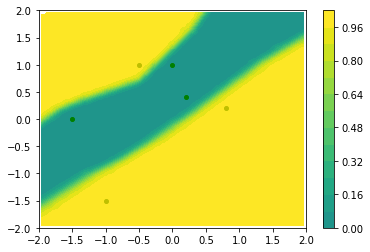

In [15]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import matplotlib.mlab as mlab
import time
%matplotlib inline

import numpy as np
import math

def actF(x):
    act = math.tanh(x)
    return [act, 1-act*act]

def actRELU(x):
    act = x if x > 0 else 0
    actDeriv = 1 if x > 0 else 0
    return [act, actDeriv]

def actIdentity(x):
    act = x
    actDeriv = 1
    return [act, actDeriv]

class NodeLayer:

    def __init__(self, 
                 nrNodes, 
                 outputLayer=False, 
                 activationFunction=None):
        self.nrNodes = nrNodes
        self.outputLayer = outputLayer
        self.bottom_values = np.zeros([nrNodes])
        self.top_values = np.zeros([nrNodes])
        self.derivative_of_values = np.zeros([nrNodes])

        self.top_error_grad = np.zeros([nrNodes])
        self.bottom_error_grad = np.zeros([nrNodes])
        self.actF = actF if activationFunction is None   \
                            else activationFunction
        
    def forward_pass(self):
        if self.outputLayer == False:
            for nodeNo in range(self.nrNodes):
                self.top_values[nodeNo],                 \
                self.derivative_of_values[nodeNo] =      \
                     self.actF(self.bottom_values[nodeNo])
    
    def backward_pass(self):
        for nodeNo in range(self.nrNodes):
            self.bottom_error_grad[nodeNo] =            \
            self.derivative_of_values[nodeNo] * self.top_error_grad[nodeNo]
            
    def softmax_normalization(self):
        self.top_values =                               \
            np.array([math.exp(v) for v in self.bottom_values])
        softmax_sum = np.sum(self.top_values)
        self.top_values /= softmax_sum
        
    def update_weights(self, eta):
        pass
        
class WeightConnection:

    def __init__(self, nrNodesIn, nrNodesOut):
        self.nrNodesIn=nrNodesIn
        self.nrNodesOut=nrNodesOut
        self.weights = np.random.uniform(-1,1, [nrNodesOut, nrNodesIn+1])
        
        self.bottom_values = np.zeros([nrNodesIn])
        self.top_values = np.zeros([nrNodesOut])
        self.top_error_grad = np.zeros([nrNodesOut])
        self.bottom_error_grad = np.zeros([nrNodesIn])
        self.delta = np.zeros(self.weights.shape)
        
    def forward_pass(self):
        #add 1 as value to introduce bias
        self.bottom_values = np.concatenate([self.bottom_values, [1]])
        self.top_values = self.weights.dot(self.bottom_values)


    def backward_pass(self):
        self.bottom_error_grad =                       \
            self.weights.transpose().dot(self.top_error_grad)
        
    def add_weight_gradient(self):
        self.delta += np.outer(self.top_error_grad, self.bottom_values)
        
    def update_weights(self, eta):
        self.weights = self.weights - eta * self.delta
        self.delta = np.zeros(self.weights.shape) 


#now, the network
nn = []
nn.append(NodeLayer(2))     # input nodes
nn.append(WeightConnection(2, 10))

nn.append(NodeLayer(10, activationFunction=actRELU))
nn.append(WeightConnection(10, 8))

nn.append(NodeLayer(8, activationFunction=actRELU))
nn.append(WeightConnection(8, 5))

nn.append(NodeLayer(5, activationFunction=actRELU))
nn.append(WeightConnection(5, 2))
nn.append(NodeLayer(2, outputLayer=True))

def forward_pass(nn, x):
    nn[0].top_values = x
    nn[0].derivative_of_values=np.ones(len(x))
    
    for layerNo, layer in enumerate(nn[1:]):
        layer.bottom_values = nn[layerNo].top_values
        layer.forward_pass()

    nn[-1].softmax_normalization()
    
    return nn[-1].top_values

def backward_pass(nn, target):
    nn[-1].bottom_error_grad = nn[-1].top_values - target
    for layerNo in range(len(nn)-2, -1, -1):
        nn[layerNo].top_error_grad = nn[layerNo+1].bottom_error_grad
        nn[layerNo].backward_pass()
        
def forward_backward_pass(nn, x, y):
    forward_pass(nn, x)
    backward_pass(nn, y)

    #only the weight connection layers
    for layerNo in range(1,len(nn), 2): 
        nn[layerNo].add_weight_gradient()
        
def update_weights(nn, eta):

    for layer in nn: #only the weight connection layers
        layer.update_weights(eta)
        
def training(nn, tr, steps, eta):
    for _ in range(steps):
        for x,y in tr:
            forward_backward_pass(nn, x, y)
            update_weights(nn, eta)
            
        
#training
tr = [
    ([0.8,0.2], [1, 0]),
    ([-0.5, 1], [1, 0]),
    ([-1, -1.5], [1, 0]),
    
    
    ([0.0, 1], [0,1]),
    ([0.2, 0.4], [0, 1]),
    ([-1.5, 0], [0, 1])
]

start = time.clock()
training(nn, tr, steps=1000, eta=0.01)
print('training in seconds: %f' % (time.clock() - start))

plot_it(x_min=-2, 
        x_max=2, 
        y_min=-2, 
        y_max=2, 
        npts=8000, 
        dataset=tr, 
        nn_callback=forward_pass)


Now, we can create a pair of networks to work togeter to simulate an input distribution, a GAN

A generative NN, i.e. a function that maps a random number (or a random vector) to an element in the input space

Here, we use a 3d random vector input and a 2D input space

In [6]:
import random

def randomElement():
    return [random.random(), random.random(), random.random()]


#The generative neural network
generatorNN = []
generatorNN.append(NodeLayer(3))     # input nodes
generatorNN.append(WeightConnection(3, 5))
generatorNN.append(NodeLayer(5))
generatorNN.append(WeightConnection(5, 5))
generatorNN.append(NodeLayer(5))
generatorNN.append(WeightConnection(5, 5))
generatorNN.append(NodeLayer(5))
generatorNN.append(WeightConnection(5, 5))
generatorNN.append(NodeLayer(5, activationFunction=actRELU))
generatorNN.append(WeightConnection(5, 2))
generatorNN.append(NodeLayer(2, activationFunction=actIdentity))


#The discriminative neural network
discriminatorNN = []
discriminatorNN.append(NodeLayer(2))     # input nodes
discriminatorNN.append(WeightConnection(2, 5))
discriminatorNN.append(NodeLayer(5))
discriminatorNN.append(WeightConnection(5, 5))
discriminatorNN.append(NodeLayer(5))
discriminatorNN.append(WeightConnection(5, 4))
discriminatorNN.append(NodeLayer(4))
discriminatorNN.append(WeightConnection(4, 3))
discriminatorNN.append(NodeLayer(3))
discriminatorNN.append(WeightConnection(3, 2))
discriminatorNN.append(NodeLayer(2, outputLayer=True))



The dataset (a spirale in this case)

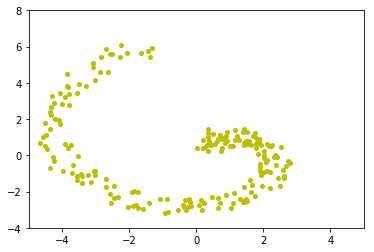

In [25]:
def polarCoordinatesToPlanar(r, a):
    return ([r*math.sin(a)+random.random(), 
             r*math.cos(a)+random.random()], 
            [1, 0]) #ground truth is (1,0) = TRUE class

tr = [polarCoordinatesToPlanar(0.03*i, 0.03*i) for i in range(200)]

plot_it(x_min=-5, 
        x_max=5, 
        y_min=-4, 
        y_max=8, 
        npts=8000, 
        dataset=tr)

The forward function of the generative NN (note, that we don't use softmax)

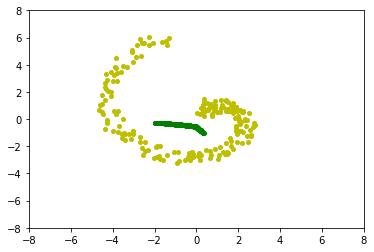

In [26]:
def forward_pass_no_softmax(nn,x):
    nn[0].top_values = x

    for layerNo, layer in enumerate(nn[1:]):
        layer.bottom_values = nn[layerNo].top_values
        layer.forward_pass()
    
    nn[-1].forward_pass()
    return nn[-1].top_values

def sample_elem(nn):
    z = np.copy (forward_pass_no_softmax(nn, randomElement()))
    return z

def plot_generation_G(nn):
    sample_set = [(sample_elem(generatorNN), [0,1]) for _ in range(200)]
    plot_it(x_min=-8,  x_max=8, 
            y_min=-8,  y_max=8, 
            npts=8000, 
            dataset=sample_set+tr)

    
plot_generation_G(generatorNN)


A backward pass that takes an error gradient as input instead of computing it implicitly using softmax/cross-entropy

In [20]:
def backward_pass_external_errorGradient(nn, err_grad):
    nn[-1].top_error_grad = err_grad
    nn[-1].backward_pass()
    for layerNo in range(len(nn)-2, -1, -1):
        nn[layerNo].top_error_grad = nn[layerNo+1].bottom_error_grad
        nn[layerNo].backward_pass()
        
        
    

A forward-backward-pass with a random element
- random -> G -> D -> ground truth = false

In [21]:
def forward_backward_Rand_G_D(nnG, nnD):
    #get random element 
    x = randomElement()
    # element is fake data, set ground truth to [0, 1]
    groundTruth = [0,1]
    
    #forward passes
    output_nnG = forward_pass_no_softmax(nnG, x)
    output_nnD = forward_pass(nnD, output_nnG)

    #backward passes
    backward_pass(nnD, groundTruth)
    backward_pass_external_errorGradient(nnG, nnD[0].bottom_error_grad)

    #add the weight gradients, only the weight connection layers
    for layerNo in range(1,len(nnG), 2):
        nnG[layerNo].add_weight_gradient()
    
    for layerNo in range(1,len(nnD), 2):
        nnD[layerNo].add_weight_gradient()

A forward backward pass with an element from the dataset is unchanged from above

In [22]:
def forward_backward_pass(nn, x, y):
    forward_pass(nn, x)
    backward_pass(nn, y)

    for layerNo in range(1,len(nn), 2):
        nn[layerNo].add_weight_gradient()

The training is now:
- take an element from the dataset, train with class [1, 0]
- take a random element and train network G and D with class [0, 1]

In [23]:


def training(nnG, nnD, tr, steps, etaD, etaG):
    for _ in range(steps):
        for x,y in tr:
            forward_backward_pass(nnD, x, y)
            z = np.copy(nnD[-1].top_values)
            classification_set.append(([z[0],1], [1, 0]))
            update_weights(nnD, etaD)
            
            forward_backward_Rand_G_D(nnG, nnD)
            z = np.copy(nnD[-1].top_values)
            classification_set.append(([z[0], 0], [0,1]))
            update_weights(nnD, etaD)
            update_weights(nnG, -etaG)
            
            

Let's train and see what happens

training in seconds: 10.758930


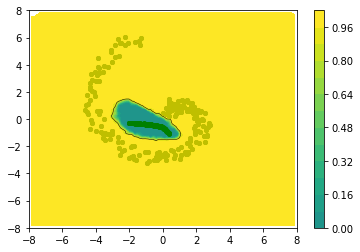

In [29]:
start = time.clock()


classification_set = []
training(nnG=generatorNN, 
         nnD=discriminatorNN, 
         tr=tr, 
         steps=100, 
         etaD=0.01, 
         etaG=0.0001)
plot_generation_G(generatorNN)

print('training in seconds: %f' % (time.clock() - start))

nn = discriminatorNN
plot_it(x_min=-8, x_max=8, 
        y_min=-8, y_max=8, 
        npts=8000, 
        dataset=tr, 
        nn_callback=forward_pass)

training in seconds: 10.414607


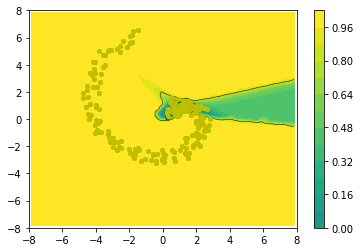

In [45]:
start = time.clock()


classification_set = []
training(nnG=generatorNN, 
         nnD=discriminatorNN, 
         tr=tr, 
         steps=100, 
         etaD=0.01, 
         etaG=0.0001)
plot_generation_G(generatorNN)

print('training in seconds: %f' % (time.clock() - start))

nn = discriminatorNN
plot_it(x_min=-8, x_max=8, 
        y_min=-8, y_max=8, 
        npts=8000, 
        dataset=tr, 
        nn_callback=forward_pass)

In [9]:
start = time.clock()


classification_set = []
training(nnG=generatorNN, 
         nnD=discriminatorNN, 
         tr=tr, 
         steps=100, 
         etaD=0.01, 
         etaG=0.0001)
plot_generation_G(generatorNN)

print('training in seconds: %f' % (time.clock() - start))

nn = discriminatorNN
plot_it(x_min=-8, x_max=8, 
        y_min=-8, y_max=8, 
        npts=8000, 
        dataset=tr, 
        nn_callback=forward_pass)

TypeError: training() got an unexpected keyword argument 'nnG'

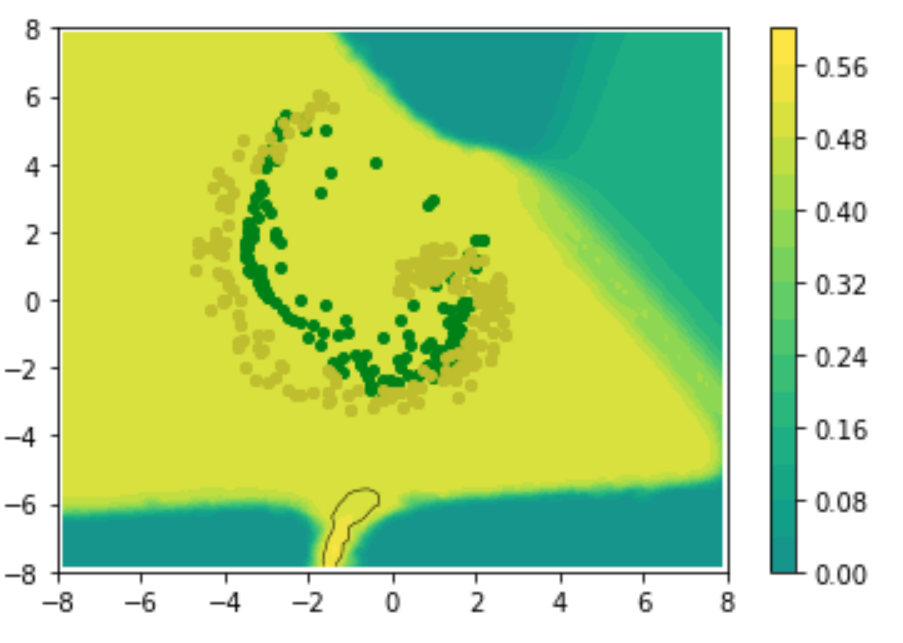

In [47]:
from IPython.display import Image 
Image(filename='distribution_after_some_time.png')